# Twitter dataset analysis

## Run pipelines

In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from pipelines import Orchestrator
from analysis_helper import AnalysisHelper

INFO - datasources.tw.tw - load config file
INFO - datasources.tw.proxy_provider - getting proxy list
INFO - datasources.tw.proxy_provider - reading proxy list json file
INFO - datasources.tw.tw - INIT Tw
DEBUG - matplotlib.pyplot - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# CONFIGS
project_name = 'datascience_conferences_single'

# cd_config = ('infomap', {})
cd_config = ('demon', {
    'epsilon': 0.25,
    'min_community_size': 3
})

In [3]:
# PIPELINE
o = Orchestrator(project_name, cd_config)
cd_results = o.execute()

INFO - pipelines.orchestrator - INIT orchestrator for datascience_conferences
INFO - pipelines.orchestrator - EXEC orchestrator for datascience_conferences
INFO - pipelines.event_detection.pipeline_manager - INIT pipeline for gtc-2018
INFO - pipelines.event_detection.pipeline_manager - EXEC pipeline for gtc-2018
INFO - datasources.pipeline_io - load input
DEBUG - datasources.pipeline_io - input present
INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.event_detection.create_event - INIT for gtc-2018
INFO - pipelines.event_detection.create_event - EXEC for gtc-2018
INFO - pipelines.event_detection.create_event - END for gtc-2018
INFO - pipelines.event_detection.pipeline_manager - END pipeline for gtc-2018
INFO - pipelines.event_detection.pipeline_manager - INIT pipeline for ipaw-2018
INFO - pipelines.event_detection.pipeline_manager - EXEC pipeline for ipaw-2018
INFO - datasources.pipeline_io - load input


INFO - pipelines.network_creation.create_network - INIT for ipaw-2018
INFO - pipelines.network_creation.create_network - EXEC for ipaw-2018
INFO - pipelines.network_creation.create_network - END for ipaw-2018
INFO - datasources.pipeline_io - load input
DEBUG - datasources.pipeline_io - input present
INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.network_creation.pre_processing - INIT for ipaw-2018
INFO - pipelines.network_creation.pre_processing - EXEC for ipaw-2018
INFO - pipelines.network_creation.pre_processing - END for ipaw-2018
INFO - datasources.pipeline_io - load input
DEBUG - datasources.pipeline_io - input present
INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.network_creation.create_graph - INIT for ipaw-2018
INFO - pipelines.network_creation.create_graph - EXEC for ipaw-2018
INFO - pipelines.network_creatio

INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.network_creation.create_graph - INIT for ecmlpkdd-2018
INFO - pipelines.network_creation.create_graph - EXEC for ecmlpkdd-2018
INFO - pipelines.network_creation.create_graph - END for ecmlpkdd-2018
INFO - datasources.pipeline_io - load input
DEBUG - datasources.pipeline_io - input present
INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.network_creation.metrics - INIT for ecmlpkdd-2018
INFO - pipelines.network_creation.metrics - EXEC for ecmlpkdd-2018
INFO - pipelines.network_creation.metrics - END for ecmlpkdd-2018
INFO - pipelines.network_creation.pipeline_manager - END pipeline for ecmlpkdd-2018
INFO - pipelines.network_creation.pipeline_manager - INIT pipeline for msignite-2018
INFO - pipelines.network_creation.pipeline_manager - EXEC pipeline for msignite-2018
INFO - da

INFO - datasources.pipeline_io - load input
DEBUG - datasources.pipeline_io - input present
INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.community_detection.metrics - INIT for ipaw-2018
INFO - pipelines.community_detection.metrics - EXEC for ipaw-2018
INFO - pipelines.community_detection.metrics - END for ipaw-2018
INFO - pipelines.community_detection.pipeline_manager - END pipeline for ipaw-2018
INFO - pipelines.community_detection.pipeline_manager - INIT pipeline for kdd-2018
INFO - pipelines.community_detection.pipeline_manager - EXEC pipeline for kdd-2018
INFO - datasources.pipeline_io - load input
DEBUG - datasources.pipeline_io - input present
INFO - datasources.pipeline_io - load output
DEBUG - datasources.pipeline_io - output present, not executing stage
INFO - pipelines.community_detection.community_detection - INIT for kdd-2018
INFO - pipelines.community_detection.community_detection - EXEC

INFO - pipelines.orchestrator - END orchestrator for datascience_conferences
DEBUG - pipelines.orchestrator - elapsed time: 3.3951 s


## Analysis

### Community Detection analysis

#### Network graph metrics

In [4]:
print('Graph summary:')
display(AnalysisHelper.merge_dataset_results('graph_summary', cd_results))

print('Partition summary:')
for ds_name, ds in cd_results.items():
    print(f'dataset "{ds_name}"')
    display(ds[0]['partition_summary'])

Graph summary:


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
dataset_name,,,,,,,,,
gtc-2018,21,83,7.9048,9.9048,0.1976,True,1,0.7179,-0.3488
ipaw-2018,3,4,2.6667,4.0000,0.6667,True,1,0.0000,-1.0000
kdd-2018,103,453,8.7961,10.2136,0.0431,False,5,0.6281,-0.3198
nips-2017,50,195,7.8000,9.2000,0.0796,True,1,0.8260,-0.6397
tcf-2018,110,252,4.5818,7.3091,0.0210,False,3,0.0121,-0.6071
ecmlpkdd-2018,13,22,3.3846,3.3846,0.1410,False,2,0.0000,-0.5267
msignite-2018,12,45,7.5000,9.0000,0.3409,True,1,0.6615,-0.5228
ona-2018,1032,5723,11.0911,12.6667,0.0054,False,4,0.6892,-0.2054
recsys-2018,53,215,8.1132,9.5849,0.0780,False,3,0.7107,-0.3848


Partition summary:
dataset "gtc-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,15,63,8.4,10.6667,0.3,True,1,0.7369,-0.5236
1,6,18,6.0,7.3333,0.6,True,1,0.7333,-0.4545


dataset "ipaw-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN


dataset "kdd-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,22,87,7.9091,8.1818,0.1883,True,1,0.8280,-0.7510
1,6,19,6.3333,11.3333,0.6333,True,1,0.7611,-0.4954
2,5,15,6.0000,8.8000,0.7500,True,1,0.8000,-0.5544
3,7,27,7.7143,8.0000,0.6429,True,1,0.6190,-0.2383
4,4,11,5.5000,6.0000,0.9167,True,1,0.8333,-0.3750
5,5,17,6.8000,7.2000,0.8500,True,1,0.6667,-0.1333
6,6,26,8.6667,12.0000,0.8667,True,1,0.8500,-0.4587
7,13,59,9.0769,10.1538,0.3782,True,1,0.5304,-0.1975
8,30,131,8.7333,10.2667,0.1506,True,1,0.6500,-0.4064


dataset "nips-2017"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,36,139,7.7222,9.3333,0.1103,True,1,0.9476,-0.9565
1,4,10,5.0000,8.0000,0.8333,True,1,0.8333,-0.6667
2,10,34,6.8000,6.8000,0.3778,True,1,0.8139,-0.7783


dataset "tcf-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


dataset "ecmlpkdd-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


dataset "msignite-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,6,19,6.3333,6.6667,0.6333,True,1,0.8000,-0.6572
1,7,26,7.4286,9.7143,0.6190,True,1,0.6143,-0.4268


dataset "ona-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,4,11,5.5000,6.000000,0.9167,True,1,0.8333,-0.3750
1,4,11,5.5000,6.000000,0.9167,True,1,0.8333,-0.3750
2,52,206,7.9231,8.230800,0.0777,True,1,0.9631,-0.9447
3,5,16,6.4000,8.800000,0.8000,True,1,0.8000,-0.6000
4,6,19,6.3333,6.666700,0.6333,True,1,0.8000,-0.6572
5,339,1420,8.3776,8.578200,0.0124,True,1,0.9467,-0.8791
6,4,12,6.0000,12.000000,1.0000,True,1,0.8333,-0.5000
7,8,28,7.0000,7.500000,0.5000,True,1,0.8214,-0.7190
8,6,20,6.6667,8.000000,0.6667,True,1,0.8000,-0.6667


dataset "recsys-2018"


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,5,15,6.0000,6.4000,0.7500,True,1,0.8000,-0.5544
1,10,35,7.0000,7.2000,0.3889,True,1,0.8444,-0.8219
2,25,113,9.0400,10.7200,0.1883,True,1,0.7076,-0.5668
3,7,25,7.1429,11.4286,0.5952,True,1,0.7952,-0.4641
4,6,23,7.6667,8.0000,0.7667,True,1,0.6000,-0.2573


* *# nodes*: number of users.
* *# edges*: number of relations between users.
* *avg degree*: average number of edges per node.
* *avg degree*: average weigth sum per node.
* *density*: expresses the how sparse is the adjacency matrix (i.e. how likely that a node has edges). 0 for a graph without edges and 1 for a complete graph.

\begin{align}
&\begin{aligned}
d = \frac{m}{n(n-1)}
\end{aligned}\\
&\begin{aligned}
m = \text{# edges}
\end{aligned}\\
&\begin{aligned}
n = \text{# nodes}
\end{aligned}
\end{align}

* *connected*: for each pairs of nodes exists a path that connects them.
* *strongly connected components*: group of nodes for which for each pair of nodes exists a path that connects them. Can be broadly relatable to the concept of community.
* *avg clustering*: average for each node of the fraction of possible triangles through that node that exist.
* *assortativity*: measures how much nodes are likely to connect to nodes with the same degree (>0) or with a different degree (<0).

#### Partition quality metrics

In [5]:
for ds_name, ds in cd_results.items():
    print(f'dataset "{ds_name}":')
    display(ds[0]['pquality'])

dataset "gtc-2018":


,min,max,avg,std
index,,,,
internal_density,0.150000,0.300000,0.225000,0.075000
edges_inside,0.150000,0.300000,0.225000,0.075000
normalized_cut,0.032264,0.034661,0.033462,0.001198
avg_degree,6.000000,8.400000,7.200000,1.200000
fomd,0.166667,0.333333,0.250000,0.083333
expansion,0.066667,0.166667,0.116667,0.050000
cut_ratio,0.011111,0.011111,0.011111,0.000000
conductance,0.007874,0.027027,0.017451,0.009577
max_odf,2.000000,2.000000,2.000000,0.000000


dataset "ipaw-2018":


,min,max,avg,std
index,,,,
internal_density,0.000000,0.0,0.000000,0.000000
edges_inside,0.000000,0.0,0.000000,0.000000
normalized_cut,1.111111,1.2,1.140741,0.041903
avg_degree,0.000000,0.0,0.000000,0.000000
fomd,0.000000,0.0,0.000000,0.000000
expansion,1.000000,2.0,1.333333,0.471405
cut_ratio,0.500000,1.0,0.666667,0.235702
conductance,1.000000,1.0,1.000000,0.000000
max_odf,2.000000,4.0,2.666667,0.942809


dataset "kdd-2018":


,min,max,avg,std
index,,,,
internal_density,0.075287,0.458333,0.279883,0.142075
edges_inside,0.075287,0.458333,0.279883,0.142075
normalized_cut,0.000000,0.186669,0.069625,0.071733
avg_degree,5.500000,9.076923,7.513363,1.203807
fomd,0.200000,0.500000,0.380518,0.091789
expansion,0.000000,1.300000,0.519172,0.531410
cut_ratio,0.000000,0.017808,0.006143,0.006436
conductance,0.000000,0.155556,0.057273,0.058768
max_odf,0.000000,30.000000,8.400000,9.789790


dataset "nips-2017":


,min,max,avg,std
index,,,,
internal_density,0.055159,0.416667,0.220238,0.149240
edges_inside,0.055159,0.416667,0.220238,0.149240
normalized_cut,0.034744,0.177362,0.094693,0.060399
avg_degree,5.000000,7.722222,6.507407,1.130437
fomd,0.055556,0.500000,0.285185,0.181746
expansion,0.166667,1.000000,0.455556,0.385221
cut_ratio,0.005000,0.021739,0.012881,0.006869
conductance,0.021127,0.166667,0.072122,0.066922
max_odf,2.000000,8.000000,4.000000,2.828427


dataset "tcf-2018":


,min,max,avg,std
index,,,,
internal_density,0.000000,0.000000,0.000000,0.000000
edges_inside,0.000000,0.000000,0.000000,0.000000
normalized_cut,1.001980,1.154362,1.004276,0.014534
avg_degree,0.000000,0.000000,0.000000,0.000000
fomd,0.000000,0.000000,0.000000,0.000000
expansion,1.000000,92.000000,2.290909,8.661666
cut_ratio,0.009174,0.844037,0.021018,0.079465
conductance,1.000000,1.000000,1.000000,0.000000
max_odf,2.000000,184.000000,4.581818,17.323332


dataset "ecmlpkdd-2018":


,min,max,avg,std
index,,,,
internal_density,0.000000,0.000000,0.000000,0.000000
edges_inside,0.000000,0.000000,0.000000,0.000000
normalized_cut,1.022222,1.137255,1.035976,0.030545
avg_degree,0.000000,0.000000,0.000000,0.000000
fomd,0.000000,0.000000,0.000000,0.000000
expansion,1.000000,7.000000,1.692308,1.587674
cut_ratio,0.083333,0.583333,0.141026,0.132306
conductance,1.000000,1.000000,1.000000,0.000000
max_odf,2.000000,14.000000,3.384615,3.175349


dataset "msignite-2018":


,min,max,avg,std
index,,,,
internal_density,0.309524,0.316667,0.313095,0.003571
edges_inside,0.309524,0.316667,0.313095,0.003571
normalized_cut,0.087037,0.203998,0.145518,0.058481
avg_degree,6.333333,7.428571,6.880952,0.547619
fomd,0.142857,0.333333,0.238095,0.095238
expansion,0.333333,0.714286,0.523810,0.190476
cut_ratio,0.055556,0.142857,0.099206,0.043651
conductance,0.050000,0.087719,0.068860,0.018860
max_odf,4.000000,10.000000,7.000000,3.000000


dataset "ona-2018":


,min,max,avg,std
index,,,,
internal_density,0.006196,0.583333,0.182787,0.163602
edges_inside,0.006196,0.583333,0.182787,0.163602
normalized_cut,0.000000,0.654453,0.264323,0.188474
avg_degree,5.500000,14.716981,8.917916,2.440760
fomd,0.076923,0.500000,0.404528,0.099550
expansion,0.000000,14.190476,4.045535,3.737899
cut_ratio,0.000000,0.014036,0.004084,0.003735
conductance,0.000000,0.628692,0.249513,0.179025
max_odf,0.000000,178.000000,70.775513,65.167686


dataset "recsys-2018":


,min,max,avg,std
index,,,,
internal_density,0.094167,0.383333,0.268913,0.110682
edges_inside,0.094167,0.383333,0.268913,0.110682
normalized_cut,0.000000,0.067475,0.019798,0.025193
avg_degree,6.000000,9.040000,7.369905,0.994214
fomd,0.200000,0.500000,0.369714,0.102596
expansion,0.000000,0.400000,0.116571,0.151039
cut_ratio,0.000000,0.008333,0.002573,0.003099
conductance,0.000000,0.062500,0.017303,0.023720
max_odf,0.000000,4.000000,1.600000,1.496663


Survey of community measures: https://github.com/Lab41/survey-community-detection 
* *Internal density*: number of edges (ms) in subset S divided by the total number of possible edges between all nodes (ns(ns-1)/2). Higher the better
* *Average degree*: average internal degree across all nodes (ns) in subset S. Higher the better.
* *FOMD (Fraction over median degree)*: Determines the number of nodes that have an internal degree greater than the median degree of nodes in Subset S. Higher the better.
* *Expansion*: can be thought as “External Degree”. Measure of separability. Lower the better.
* *Cut Ratio*: This metric is a measure of separability and can be thought of as "External Density". Lower the better.
* *Conductance*: Ratio of edges inside the cluster to the number of edges leaving the cluster (captures surface area to volume). Higher the better.
* *Normalized Cut*: Represents how well subset S is separated from graph G. Combines Conductance with the fraction of external edges over all non-community edges. Higher the better.
* *Maximum ODF (Out Degree Fraction)*: Fraction of external conections to internal connections for each node (ns) in S. It then returns the fraction with the highest value. Lower the better.
* *Average ODF*: same as Maximum ODF but takes the average. Lower the better.
* *Flake-ODF*: Fraction of the number of nodes that have fewer internal connections than external connections to the number of nodes (ns) in subset S. Higher the better.

#### Cuulative sum of degree distribution

DEBUG - matplotlib.font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG - matplotlib.axes._base - update_title_pos
DEBUG - matplotlib.font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG - matplotlib.axes._base - update_title_pos
DEBUG - matplotlib.axes._base - update_title_pos
DEBUG - matplotlib.axes._base - update_title_pos
DEBUG - matplotlib.axes._base - update_title_pos


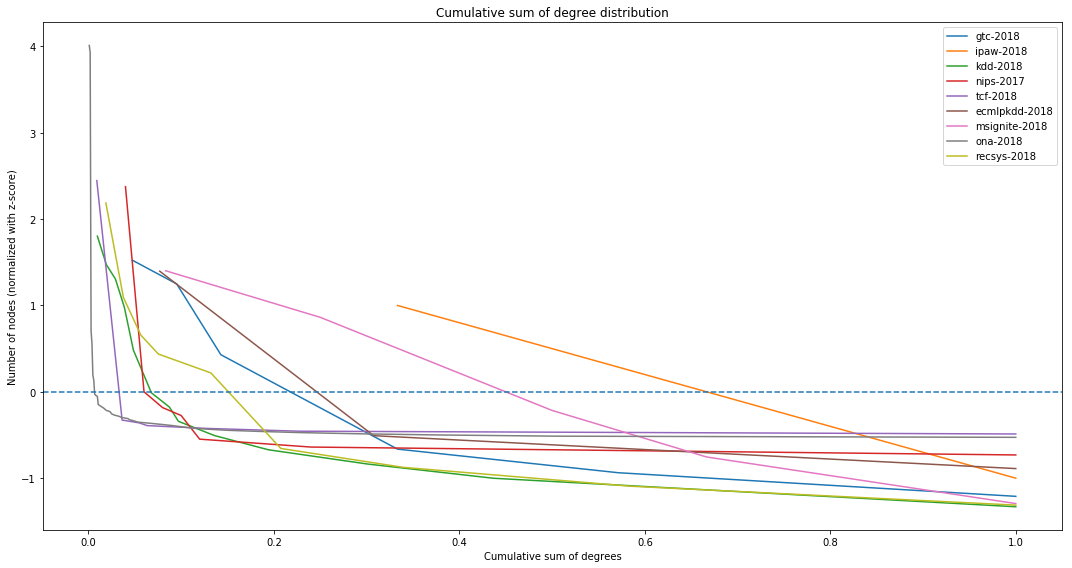

In [6]:
AnalysisHelper.plot_compare_cumsum_deg_dist(cd_results)

Cumulative sum of degree distribution shows how the degree is distributed with respect to the number of nodes.

* Nodes with a lower degree (left on the plot) are typically way less than the ones with a high degree (right on the plot).

* Over the dotted line there's a number of node above the mean (the converse below the line) as per z-score.

* Z-score normalization for the number of nodes has been chosen because it preserves the range (maximum and minimum) and introduces the dispersion of the serie (standard deviation / variance)

\begin{align}
P(k) = \frac{\text{# nodes with degree >= k}}{\text{# nodes}}
\end{align}

Cumulative sum of degree distribution is more robust wrt the simple degree distribution because is less subject to small numbers. 